In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

# Load data

In [2]:
import pandas as pd
df = pd.read_csv('weatherDef.csv')
df

,Loc,MinT,MaxT,Rain,WDir,WSpeed,WDir9,WDir3,WSpeed9,WSpeed3,Hum9,Hum3,Press9,Press3,Temp9,Temp3,Rtod,RTom
0,0,10.0,26.2,0.0,14,37,0,14,4,20,67,25,1013.8,1011.8,17.1,24.9,0,0
1,0,14.3,21.6,19.2,15,50,14,15,9,28,98,44,1011.8,1010.3,14.5,20.2,1,0
2,0,0.2,13.6,0.0,14,30,2,13,7,19,100,50,1022.9,1020.5,4.0,13.0,0,0
3,0,17.5,30.0,1.0,12,43,0,13,6,30,75,35,1005.4,1000.5,22.2,28.4,0,0
4,0,15.2,26.3,0.0,13,43,15,13,20,26,54,24,1010.9,1009.8,19.4,24.8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23167,46,8.0,15.2,2.4,15,39,14,15,11,22,85,64,1020.0,1021.1,11.2,12.4,1,1
23168,46,7.0,20.1,0.0,15,46,5,13,19,15,65,94,1019.9,1018.6,14.8,14.0,0,1
23169,46,9.8,17.3,0.0,5,52,5,5,20,15,81,65,1017.8,1012.5,13.8,16.5,0,1
23170,46,3.6,15.1,0.6,3,37,4,7,6,13,96,54,1019.6,1019.3,7.3,13.3,0,1


# Split train and test

In [3]:
columnas = df.columns
X = df[columnas[:-1]]
y = df[columnas[-1]]

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocesing for SVM

We will try both datasets, one with minmax scaler and another one with standarized data.

In [5]:
from sklearn.preprocessing import StandardScaler
scaler_std = StandardScaler()

X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler_mm = MinMaxScaler()

X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

# Linear kernel SVM
## With minmax

In [20]:
from sklearn.svm import LinearSVC, SVC
import numpy as np
from skopt import BayesSearchCV

param = {'C':10**np.linspace(-3,3,101)}

cv = 5
n_iter = 15

lsvc_mm = SVC(kernel='linear', max_iter=25000, random_state=0)
lsvc_gs_mm = BayesSearchCV(lsvc_mm,param,n_iter=n_iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
lsvc_gs_mm.fit(X_train_mm, y_train);

C:\Python\Python39\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [43]:
show_html(pd.DataFrame(lsvc_gs_mm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
14,{'C': 15.848931924611142},0.752387,1
0,{'C': 1.513561248436207},0.751848,2
2,{'C': 1.513561248436207},0.751848,2
7,{'C': 1.1481536214968828},0.751254,4
9,{'C': 0.16595869074375597},0.748125,5


In [75]:
knc = lsvc_gs_mm.best_estimator_
print("\nNumber of supports: ",np.sum(knc.n_support_))


Number of supports:  10835


              precision    recall  f1-score   support

           0       0.74      0.71      0.72      2058
           1       0.78      0.79      0.79      2577

    accuracy                           0.76      4635
   macro avg       0.76      0.75      0.76      4635
weighted avg       0.76      0.76      0.76      4635



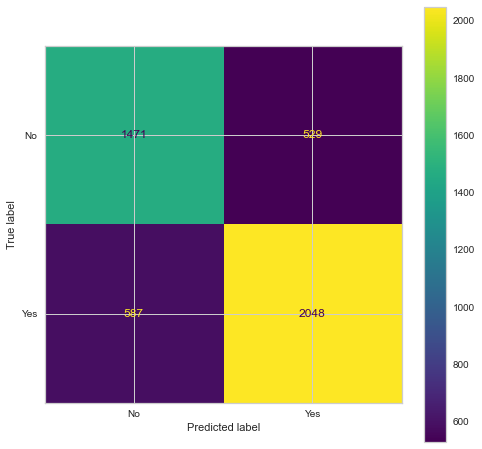

In [21]:
from sklearn.metrics import  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print(classification_report(lsvc_gs_mm.predict(X_test_mm), y_test))

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lsvc_gs_mm, X_test_mm, y_test, display_labels=['No', 'Yes'], ax=plt.subplot());

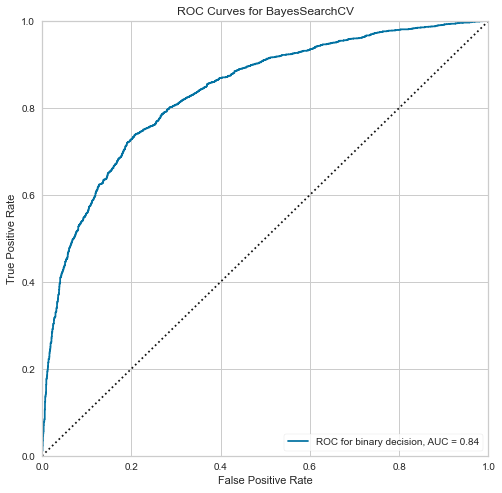

In [22]:
from yellowbrick.classifier.rocauc import roc_auc

plt.figure(figsize=(8,8));
roc_auc(lsvc_gs_mm, X_train_mm, y_train, X_test_mm, y_test, binary=True, classes=['No', 'Yes']);

## With standarized data

In [23]:
param = {'C':10**np.linspace(-3,3,101)}

cv = 5
n_iter = 15

lsvc_std = SVC(kernel='linear', max_iter=25000, random_state=0)
lsvc_gs_std = BayesSearchCV(lsvc_std,param,n_iter=n_iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
lsvc_gs_std.fit(X_train_std, y_train);

C:\Python\Python39\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [44]:
show_html(pd.DataFrame(lsvc_gs_std.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
9,{'C': 0.16595869074375597},0.752387,1
10,{'C': 0.1096478196143185},0.751955,2
1,{'C': 0.03630780547701014},0.751794,3
11,{'C': 0.013803842646028845},0.751578,4
4,{'C': 0.023988329190194897},0.751146,5


In [78]:
knc = lsvc_gs_std.best_estimator_
print("\nNumber of supports: ",np.sum(knc.n_support_))


Number of supports:  10692


              precision    recall  f1-score   support

           0       0.74      0.71      0.73      2075
           1       0.77      0.80      0.79      2560

    accuracy                           0.76      4635
   macro avg       0.76      0.76      0.76      4635
weighted avg       0.76      0.76      0.76      4635



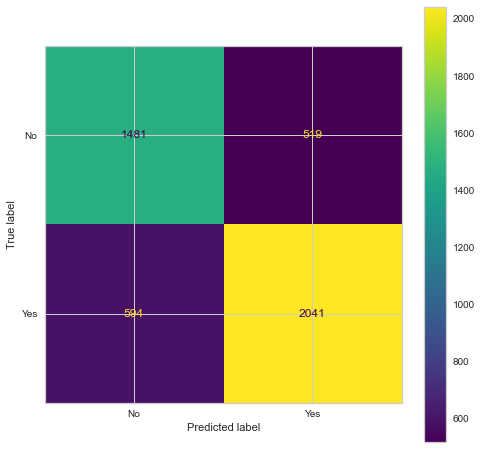

In [24]:
print(classification_report(lsvc_gs_std.predict(X_test_std), y_test))

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lsvc_gs_std, X_test_std, y_test, display_labels=['No', 'Yes'], ax=plt.subplot());

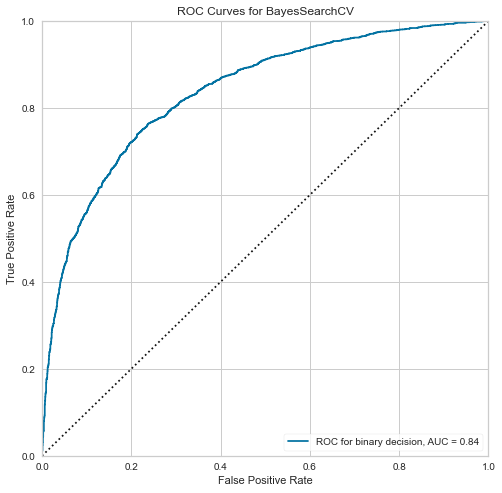

In [25]:
plt.figure(figsize=(8,8));
roc_auc(lsvc_gs_std, X_train_std, y_train, X_test_std, y_test, binary=True,classes=['No', 'Yes']);

# Polynomic kernel SVM
## With minmax

In [47]:
param = {'C':10**np.linspace(-3,3,101), 'degree':[2,3,5,10]}

cv = 5
niter = 15

psvc_mm =  SVC(kernel='poly', max_iter=25000, random_state=0)
psvc_gs_mm = BayesSearchCV(psvc_mm,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
psvc_gs_mm.fit(X_train_mm, y_train);

C:\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Python\Python39\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [48]:
show_html(pd.DataFrame(psvc_gs_mm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
3,"{'C': 0.007943282347242814, 'degree': 5}",0.761342,1
9,"{'C': 0.16595869074375597, 'degree': 3}",0.760857,2
11,"{'C': 0.16595869074375597, 'degree': 3}",0.760857,2
2,"{'C': 1.513561248436207, 'degree': 2}",0.759939,4
4,"{'C': 0.023988329190194897, 'degree': 3}",0.756811,5


In [79]:
knc = psvc_gs_mm.best_estimator_
print("\nNumber of supports: ",np.sum(knc.n_support_))


Number of supports:  10420


              precision    recall  f1-score   support

           0       0.77      0.71      0.74      2174
           1       0.76      0.81      0.79      2461

    accuracy                           0.76      4635
   macro avg       0.77      0.76      0.76      4635
weighted avg       0.77      0.76      0.76      4635



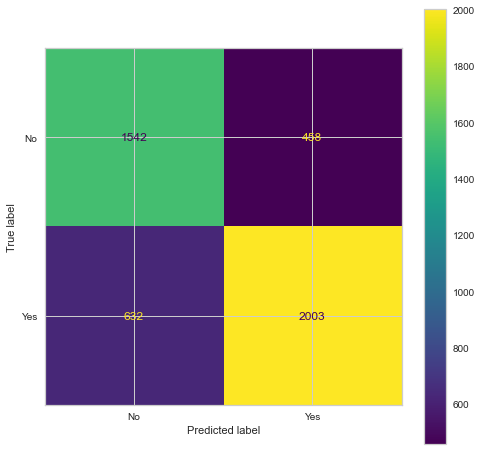

In [49]:
print(classification_report(psvc_gs_mm.predict(X_test_mm), y_test))


plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(psvc_gs_mm, X_test_mm, y_test, display_labels=['No', 'Yes'], ax=plt.subplot());

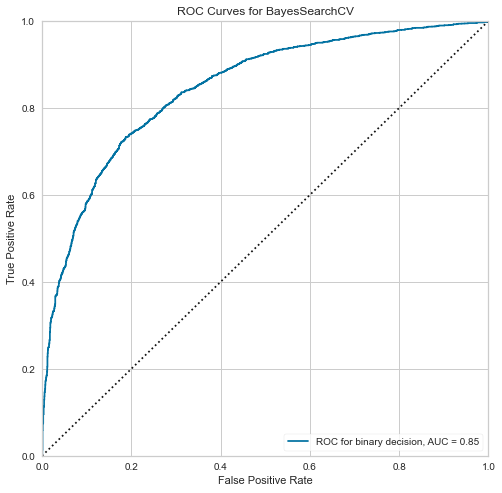

In [50]:
plt.figure(figsize=(8,8));
roc_auc(psvc_gs_mm, X_train_mm, y_train, X_test_mm, y_test, binary=True,classes=['No', 'Yes']);

## With standarized data

In [51]:
param = {'C':10**np.linspace(-3,3,101), 'degree':[2,3,5,10]}

cv = 5
n_iter = 15

psvc_std =  SVC(kernel='poly', max_iter=25000, random_state=0)
psvc_gs_std = BayesSearchCV(psvc_std,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
psvc_gs_std.fit(X_train_std, y_train);

C:\Python\Python39\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [52]:
show_html(pd.DataFrame(psvc_gs_std.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
13,"{'C': 1.1481536214968828, 'degree': 3}",0.760155,1
9,"{'C': 0.16595869074375597, 'degree': 3}",0.755840,2
0,"{'C': 1.513561248436207, 'degree': 5}",0.749042,3
7,"{'C': 1.1481536214968828, 'degree': 5}",0.746129,4
4,"{'C': 0.023988329190194897, 'degree': 3}",0.731672,5


In [80]:
knc = psvc_gs_std.best_estimator_
print("\nNumber of supports: ",np.sum(knc.n_support_))


Number of supports:  10791


              precision    recall  f1-score   support

           0       0.76      0.74      0.75      2065
           1       0.79      0.81      0.80      2570

    accuracy                           0.78      4635
   macro avg       0.78      0.77      0.78      4635
weighted avg       0.78      0.78      0.78      4635



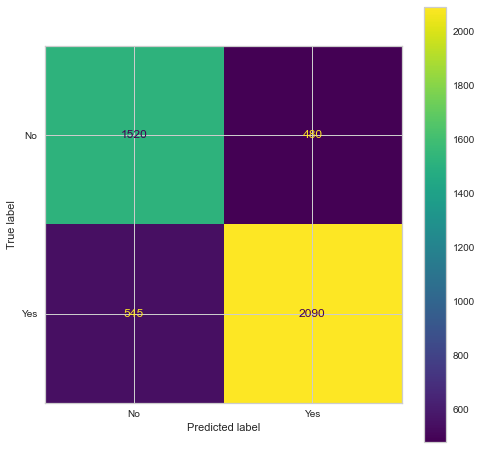

In [53]:
print(classification_report(psvc_gs_std.predict(X_test_std), y_test))


plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(psvc_gs_std, X_test_std, y_test, display_labels=['No', 'Yes'], ax=plt.subplot());

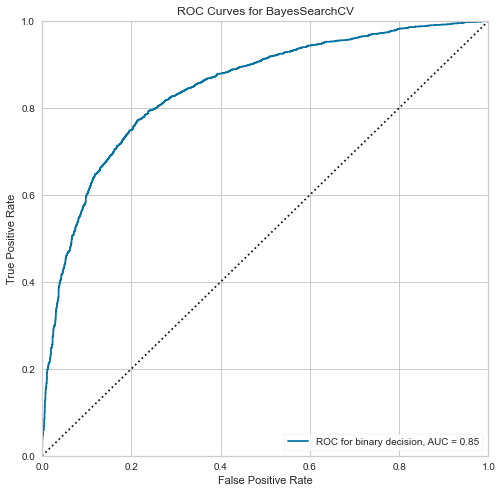

In [54]:
plt.figure(figsize=(8,8));
roc_auc(psvc_gs_std, X_train_std, y_train, X_test_std, y_test, binary=True,classes=['No', 'Yes']);

# RBF kernel SVM
## With minmax

In [32]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto']}

rbsvc_mm =  SVC(kernel='rbf', max_iter=25000, random_state=0)
rbsvc_gs_mm = BayesSearchCV(rbsvc_mm,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rbsvc_gs_mm.fit(X_train_mm, y_train);

C:\Python\Python39\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [55]:
show_html(pd.DataFrame(rbsvc_gs_mm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
12,"{'C': 6.918309709189362, 'gamma': 'scale'}",0.774343,1
0,"{'C': 1.513561248436207, 'gamma': 'scale'}",0.768193,2
7,"{'C': 1.1481536214968828, 'gamma': 'scale'}",0.767007,3
10,"{'C': 331.13112148259074, 'gamma': 'auto'}",0.765334,4
13,"{'C': 125.89254117941663, 'gamma': 'auto'}",0.765226,5


In [81]:
knc = rbsvc_gs_mm.best_estimator_
print("\nNumber of supports: ",np.sum(knc.n_support_))


Number of supports:  9755


              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1994
           1       0.81      0.81      0.81      2641

    accuracy                           0.78      4635
   macro avg       0.78      0.78      0.78      4635
weighted avg       0.78      0.78      0.78      4635



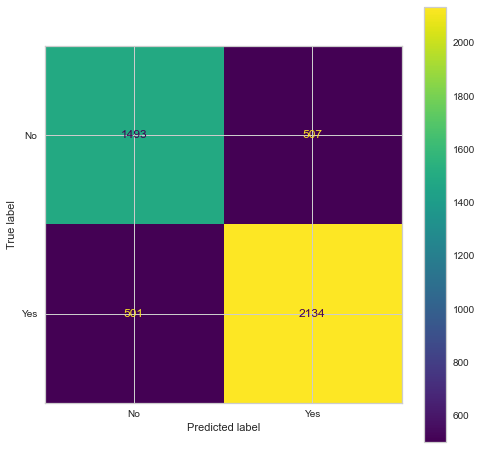

In [41]:
print(classification_report(rbsvc_gs_mm.predict(X_test_mm), y_test))

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rbsvc_gs_mm, X_test_mm, y_test, display_labels=['No', 'Yes'], ax=plt.subplot());

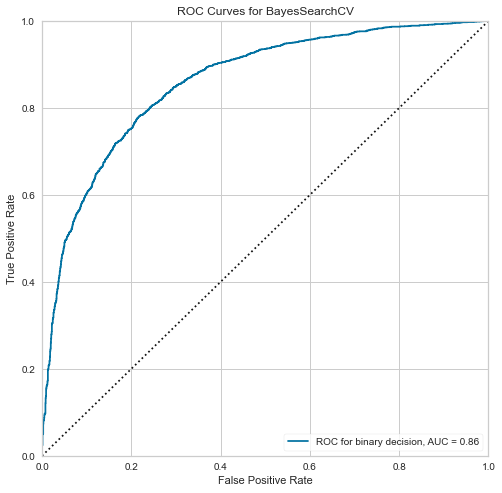

In [34]:
plt.figure(figsize=(8,8));
roc_auc(rbsvc_gs_mm, X_train_mm, y_train, X_test_mm, y_test, binary=True,classes=['No', 'Yes']);

## With standarized data

In [35]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto']}

rbsvc_std =  SVC(kernel='rbf', max_iter=25000, random_state=0)
rbsvc_gs_std = BayesSearchCV(rbsvc_std,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rbsvc_gs_std.fit(X_train_std, y_train);

In [56]:
show_html(pd.DataFrame(rbsvc_gs_std.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
2,"{'C': 1.513561248436207, 'gamma': 'auto'}",0.774236,1
0,"{'C': 1.513561248436207, 'gamma': 'scale'}",0.774182,2
12,"{'C': 6.918309709189362, 'gamma': 'scale'}",0.774127,3
7,"{'C': 1.1481536214968828, 'gamma': 'scale'}",0.773804,4
9,"{'C': 0.16595869074375597, 'gamma': 'auto'}",0.766467,5


In [82]:
knc = rbsvc_gs_std.best_estimator_
print("\nNumber of supports: ",np.sum(knc.n_support_))


Number of supports:  9901


              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1992
           1       0.81      0.81      0.81      2643

    accuracy                           0.79      4635
   macro avg       0.78      0.78      0.78      4635
weighted avg       0.79      0.79      0.79      4635



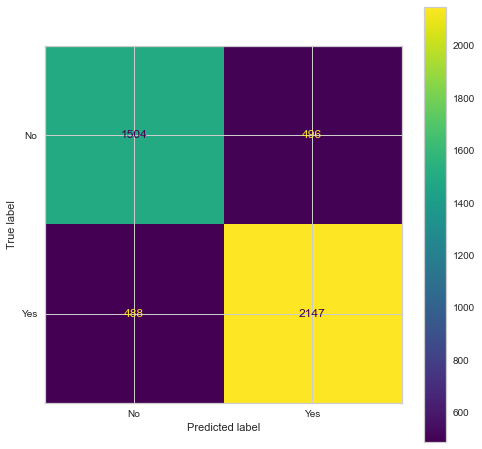

In [38]:
print(classification_report(rbsvc_gs_std.predict(X_test_std), y_test))

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rbsvc_gs_std, X_test_std, y_test, display_labels=['No', 'Yes'], ax=plt.subplot());

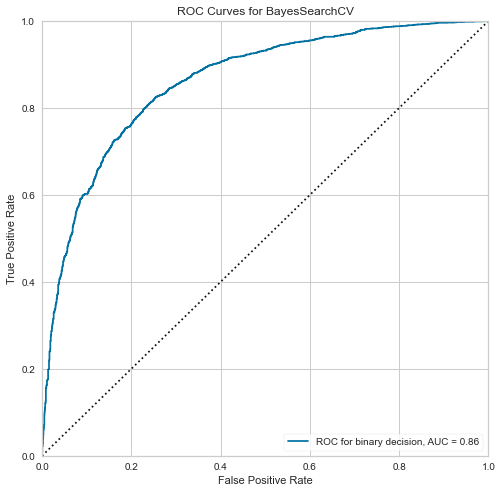

In [37]:
plt.figure(figsize=(8,8));
roc_auc(rbsvc_gs_std, X_train_std, y_train, X_test_std, y_test, binary=True,classes=['No', 'Yes']);

# SVM on PCA

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.svm import LinearSVC, SVC
import numpy as np
from skopt import BayesSearchCV

pca = PCA().fit(X_train_std);

We will only keep with the 7th firsts dimensions of the PCA that makes us to have an accumulative variance of more than the 80%.

In [22]:
X_trans = pca.transform(X_train_std)[:, :7]
X_pca_test = pca.transform(X_test_std)[:, :7]

## With linear kernal

In [23]:
param = {'C':10**np.linspace(-3,3,101)}

cv = 5
n_iter = 15

linear = SVC(kernel='linear', max_iter=25000, random_state=0)
linear_svc = BayesSearchCV(linear,param,n_iter=n_iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
linear_svc.fit(X_trans, y_train);

In [24]:
show_html(pd.DataFrame(linear_svc.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
10,{'C': 0.1096478196143185},0.729191,1
4,{'C': 0.023988329190194897},0.729083,2
1,{'C': 0.03630780547701014},0.729029,3
9,{'C': 0.16595869074375597},0.728975,4
11,{'C': 0.013803842646028845},0.728975,5


In [25]:
knc = linear_svc.best_estimator_
print("\nNumber of supports: ",np.sum(knc.n_support_))


Number of supports:  11610


              precision    recall  f1-score   support

           0       0.68      0.69      0.68      1972
           1       0.77      0.76      0.76      2663

    accuracy                           0.73      4635
   macro avg       0.72      0.72      0.72      4635
weighted avg       0.73      0.73      0.73      4635



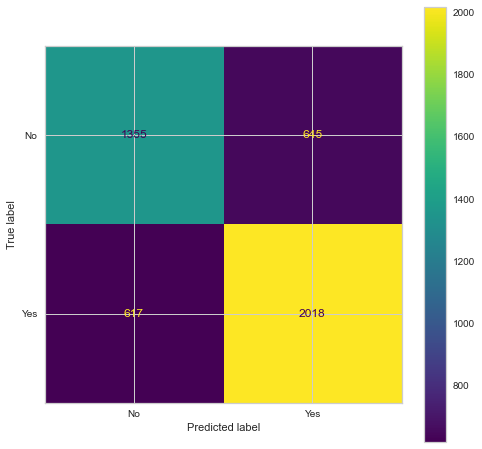

In [26]:
print(classification_report(linear_svc.predict(X_pca_test), y_test))


plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(linear_svc, X_pca_test, y_test, display_labels=['No', 'Yes'], ax=plt.subplot());

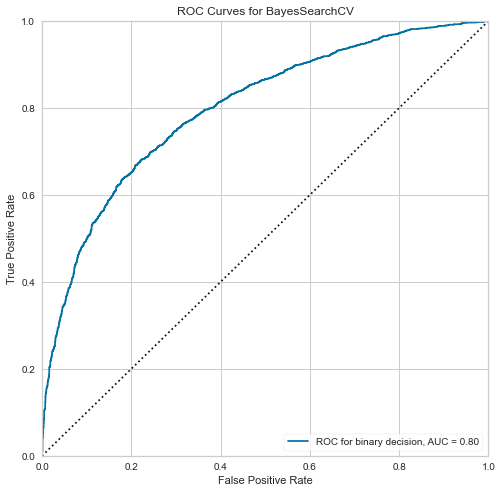

In [27]:
plt.figure(figsize=(8,8));
roc_auc(linear_svc, X_trans, y_train, X_pca_test, y_test, binary=True,classes=['No', 'Yes']);

## With polynomical kernel

In [28]:
param = {'C':10**np.linspace(-3,3,101), 'degree':[2,3,5,10]}

cv = 5
niter = 15

poly =  SVC(kernel='poly', max_iter=25000, random_state=0)
poly_svc = BayesSearchCV(poly,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
poly_svc.fit(X_trans, y_train);

C:\Python\Python39\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [29]:
show_html(pd.DataFrame(poly_svc.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
11,"{'C': 1.513561248436207, 'degree': 3}",0.731781,1
10,"{'C': 1.1481536214968828, 'degree': 3}",0.729623,2
9,"{'C': 0.16595869074375597, 'degree': 3}",0.726493,3
12,"{'C': 0.03630780547701014, 'degree': 3}",0.715057,4
4,"{'C': 0.023988329190194897, 'degree': 3}",0.709986,5


In [30]:
knc = poly_svc.best_estimator_
print("\nNumber of supports: ",np.sum(knc.n_support_))


Number of supports:  11937


              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1729
           1       0.81      0.74      0.77      2906

    accuracy                           0.73      4635
   macro avg       0.72      0.73      0.72      4635
weighted avg       0.74      0.73      0.73      4635



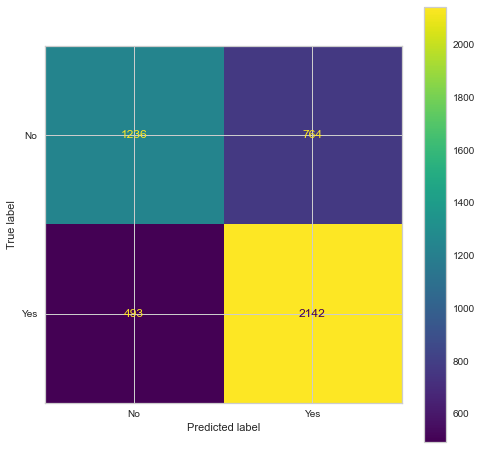

In [31]:
print(classification_report(poly_svc.predict(X_pca_test), y_test))


plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(poly_svc, X_pca_test, y_test, display_labels=['No', 'Yes'], ax=plt.subplot());

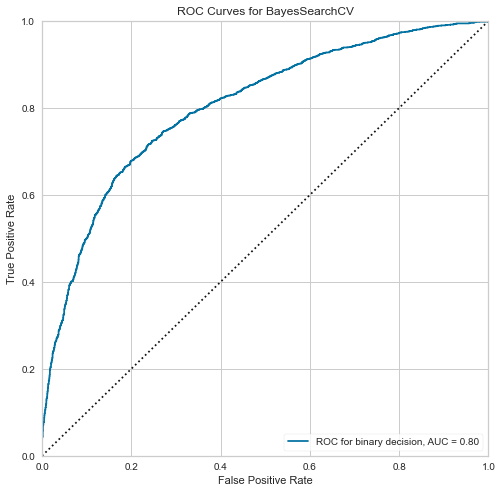

In [32]:
plt.figure(figsize=(8,8));
roc_auc(poly_svc, X_trans, y_train, X_pca_test, y_test, binary=True,classes=['No', 'Yes']);

## With RBF kernel

In [33]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto']}

rbf =  SVC(kernel='rbf', max_iter=25000, random_state=0)
rbf_svc = BayesSearchCV(rbf,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rbf_svc.fit(X_trans, y_train);

C:\Python\Python39\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [34]:
show_html(pd.DataFrame(rbf_svc.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
12,"{'C': 6.918309709189362, 'gamma': 'scale'}",0.756217,1
2,"{'C': 1.513561248436207, 'gamma': 'auto'}",0.754707,2
0,"{'C': 1.513561248436207, 'gamma': 'scale'}",0.754384,3
7,"{'C': 1.1481536214968828, 'gamma': 'scale'}",0.753952,4
9,"{'C': 0.16595869074375597, 'gamma': 'auto'}",0.752927,5


In [35]:
knc = rbf_svc.best_estimator_
print("\nNumber of supports: ",np.sum(knc.n_support_))


Number of supports:  10271


              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1942
           1       0.80      0.78      0.79      2693

    accuracy                           0.76      4635
   macro avg       0.75      0.76      0.75      4635
weighted avg       0.76      0.76      0.76      4635



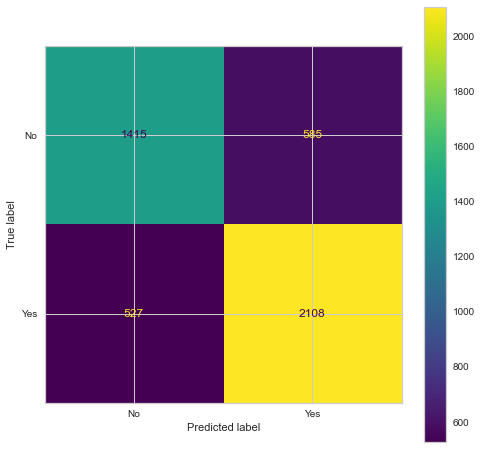

In [36]:
print(classification_report(rbf_svc.predict(X_pca_test), y_test))


plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rbf_svc, X_pca_test, y_test, display_labels=['No', 'Yes'], ax=plt.subplot());

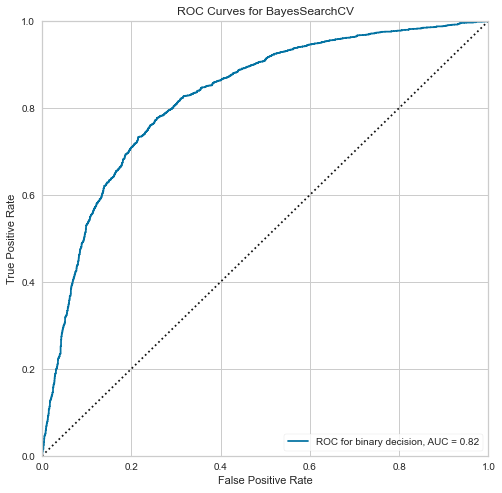

In [37]:
plt.figure(figsize=(8,8));
roc_auc(rbf_svc, X_trans, y_train, X_pca_test, y_test, binary=True,classes=['No', 'Yes']);